In [2]:
import numpy as np 
import matplotlib as mpl
%matplotlib widget
import matplotlib.pyplot as plt

import gorgon

# Define

## Import data

In [3]:
def import_stuff( filepath: str ):
    B = gorgon.import_from_bin(f"{filepath}/B_processed_real.bin")

    with open(f"{filepath}/params_cpp.csv", "r") as f:
        params = np.array( f.readline().split(","), dtype=np.float32 )
        
    interest_points_theta = []
    interest_points_phi = []
    interest_points_r = []
    interest_points_w = []
        
    with open(f"{filepath}/interest_points_cpp.csv", "r") as f:
        lines = f.readlines()

        for line in lines:
            point = np.array( line.split(","), dtype=np.float32 )
            interest_points_theta.append( point[0] )
            interest_points_phi.append( point[1] )
            interest_points_r.append( point[2] )
            interest_points_w.append( (1-point[3], point[3], point[3]) )

        interest_points_theta = np.array(interest_points_theta)
        interest_points_phi = np.array(interest_points_phi)
        interest_points_r = np.array(interest_points_r)
        interest_points_w = np.array(interest_points_w)

    return B, params, interest_points_theta, interest_points_phi, interest_points_r, interest_points_w

## Plot surface

In [4]:
def plot_surface( filename: str ):
    B, params, _, _, _, _ = import_stuff( filename )

    theta, phi = np.meshgrid( np.linspace( 0, np.pi*0.9, 40 ), np.linspace( -np.pi, np.pi, 80 ), indexing='ij' )
    R = gorgon.Me25_poly( params, theta, phi )

    earth_pos = [29.75, 58, 58]

    X,Y,Z = gorgon.spherical_to_cartesian( R, theta, phi, earth_pos )

    B_thing = B[np.array(X, dtype=np.int16), np.array(Y, dtype=np.int16), np.array(Z, dtype=np.int16)]

    B_thing_norm = np.linalg.norm( B_thing, axis=2 )

    saturation = 0.8

    B_thing_norm = B_thing_norm * (B_thing_norm < np.max(B_thing_norm)*saturation) + np.max(B_thing_norm)*saturation * (B_thing_norm >= np.max(B_thing_norm)*saturation)

    color = (B_thing_norm - np.min(B_thing_norm)) / (np.max(B_thing_norm) - np.min(B_thing_norm))
    cmap = plt.get_cmap("inferno")
    color = cmap( color )
    
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(projection='3d')
    # ax.set(xlabel=r"$x \in [-30; 128] R_E$", ylabel=r"$y \in [-58; 58] R_E$", zlabel=r"$z \in [-58; 58] R_E$")
    # plt.suptitle("Surface of the magnetopause drawn from the fitted function.")
    # plt.title("Colours represent the norm of the magnetic field.")

    ax.set_xlim(0, B.shape[0])
    ax.set_ylim(0, B.shape[1])
    ax.set_zlim(0, B.shape[2])
    
    ax.patch.set_facecolor('black')
    ax.set_axis_off()

    ax.figure.subplots_adjust(0, 0, 1, 1)

    ax.plot_surface(X, Y, Z, facecolors=color, shade=False)

    norm = mpl.colors.Normalize(vmin=np.min(B_thing_norm), vmax=np.max(B_thing_norm))
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    ax = ax, label=r"$||\mathbf{B}||$ [$T$]", shrink=0.5)

## Plot scatter

In [5]:
def plot_scatter( filename: str ):
    B, params, ip_theta, ip_phi, ip_r, ip_w = import_stuff( filename )

    earth_pos = [29.75, 58, 58]

    X,Y,Z = gorgon.spherical_to_cartesian( ip_r, ip_theta, ip_phi, earth_pos )
    
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(projection='3d')
    # ax.set(xlabel=r"$x \in [-30; 128] R_E$", ylabel=r"$y \in [-58; 58] R_E$", zlabel=r"$z \in [-58; 58] R_E$")
    # plt.suptitle("Surface of the magnetopause drawn from the fitted function.")
    # plt.title("Colours represent the norm of the magnetic field.")

    ax.set_xlim(0, B.shape[0])
    ax.set_ylim(0, B.shape[1])
    ax.set_zlim(0, B.shape[2])
    
    ax.patch.set_facecolor('black')
    ax.set_axis_off()

    ax.figure.subplots_adjust(0, 0, 1, 1)

    ax.scatter(X, Y, Z, c=ip_w)

# Main

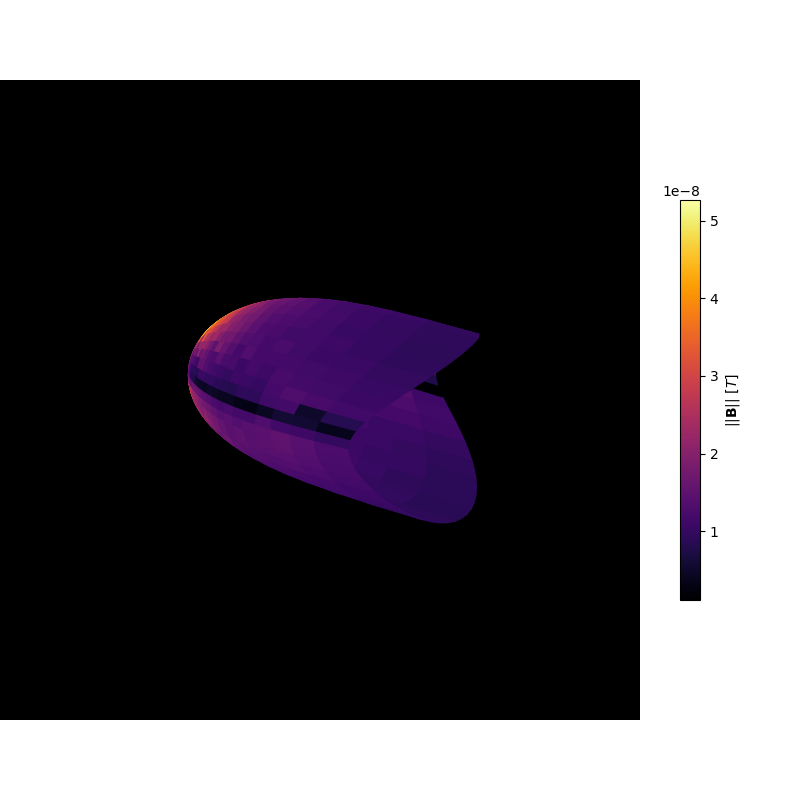

In [6]:
plot_surface( "../data/Run1_28800" )

In [7]:
plt.close()

# Rho

1

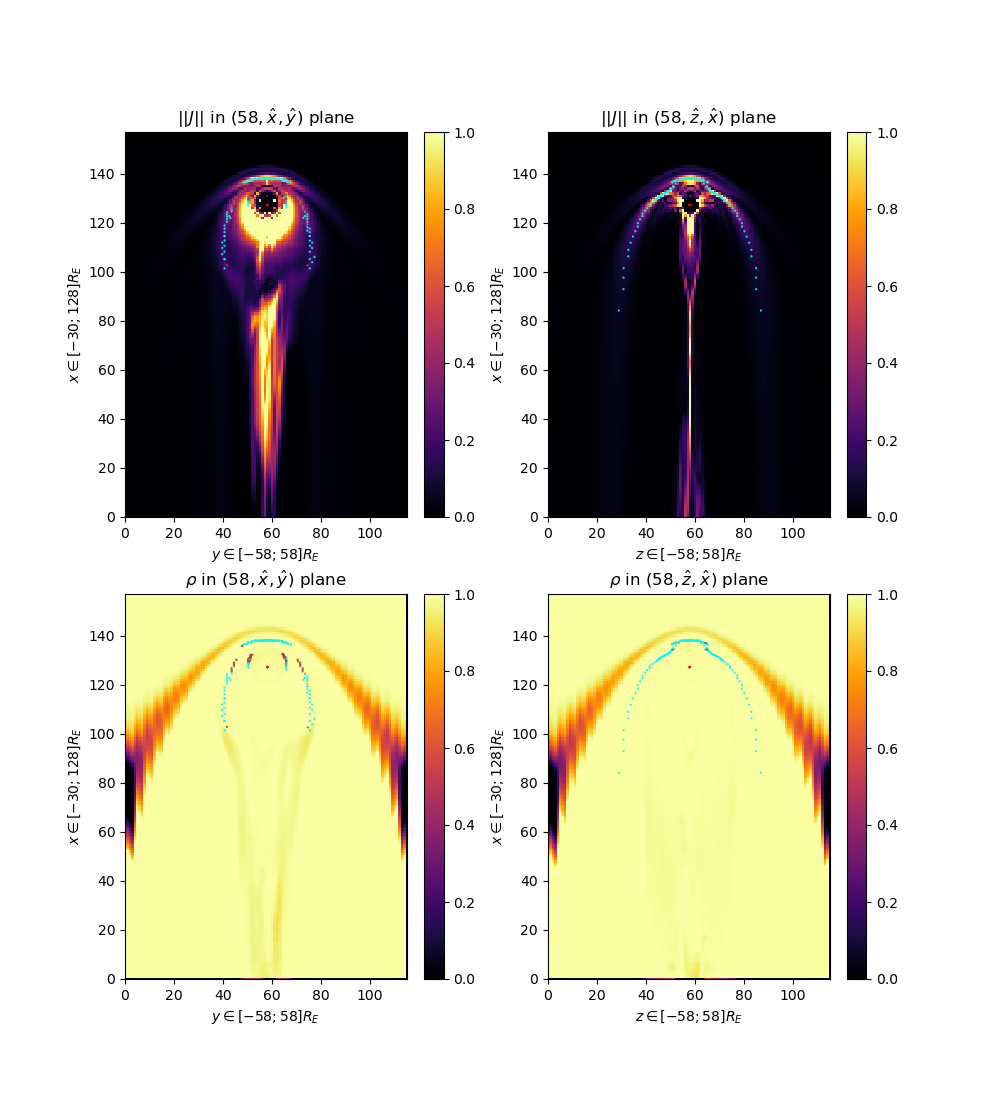

In [9]:
filename = "/rds/general/user/avr24/home/Thesis/data/Run1_22500"

J_norm = gorgon.import_from_bin( f"{filename}/J_norm_processed_real.bin" )
rho = gorgon.import_from_bin( f"{filename}/Rho_processed_real.bin" )

interest_points_theta = []
interest_points_phi = []
interest_points_r = []
interest_points_w = []

with open(f"{filename}/interest_points_cpp.csv", "r") as f:
    lines = f.readlines()

    for line in lines:
        point = np.array( line.split(","), dtype=np.float32 )
        interest_points_theta.append( point[0] )
        interest_points_phi.append( point[1] )
        interest_points_r.append( point[2] )
        interest_points_w.append( (1-point[3], point[3], point[3]) )

    interest_points_theta = np.array(interest_points_theta)
    interest_points_phi = np.array(interest_points_phi)
    interest_points_r = np.array(interest_points_r)
    interest_points_w = np.array(interest_points_w)

from gorgon import get_gradients

earth_pos = [30.75, 58, 58]
X, Y, Z = np.meshgrid( 
    np.arange(-earth_pos[0], rho.shape[0]-earth_pos[0]),
    np.arange(-earth_pos[1], rho.shape[1]-earth_pos[1]),
    np.arange(-earth_pos[2], rho.shape[2]-earth_pos[2]),
    indexing='ij'
)
R = np.maximum( np.sqrt( X*X + Y*Y + Z*Z ), 1e-3 )

d_rho_x, d_rho_y, d_rho_z = get_gradients( rho[:,:,:,0] )

d_rho_r = (d_rho_x*X + d_rho_y*Y + d_rho_z*Z) * R**3 #np.sqrt( d_rho_x**2 + d_rho_y**2 + d_rho_z**2 ) # / rho[:,:,:,0]

rho = (rho - np.min(rho))/(3e-20 - np.min(rho))
d_rho_r = (d_rho_r - np.min(d_rho_r)*0.003)/(np.max(d_rho_r)*0.001 - np.min(d_rho_r)*0.003)

J_norm = J_norm[:,:,:,0]
J_norm = (J_norm - np.min(J_norm))/(3e-9 - np.min(J_norm))

# d_rho = 1 - d_rho


fig, axes = plt.subplots(2, 2)
fig.set_figwidth(10)
fig.set_figheight(11)

iy = 58

J_norm_xy_i = J_norm[::-1,:,iy]
J_norm_xz_i = J_norm[::-1,iy,:]

rho_xy_i = d_rho_r[::-1,:,iy]
rho_xz_i = d_rho_r[::-1,iy,:]

J_xy = axes[0,0].imshow(J_norm_xy_i, cmap="inferno", vmin=0, vmax=1, interpolation="none")
plt.colorbar(J_xy, ax=axes[0,0])
axes[0,0].set_title(fr"$||J||$ in $({58},\hat x, \hat y)$ plane")

J_xz = axes[0,1].imshow(J_norm_xz_i, cmap="inferno", vmin=0, vmax=1, interpolation="none")
plt.colorbar(J_xz, ax=axes[0,1])
axes[0,1].set_title(fr"$||J||$ in $({58},\hat z, \hat x)$ plane")


rho_xy = axes[1,0].imshow(rho_xy_i, cmap="inferno", vmin=0, vmax=1, interpolation="none")
plt.colorbar(rho_xy, ax=axes[1,0])
axes[1,0].set_title(fr"$\rho$ in $({58},\hat x, \hat y)$ plane")

rho_xz = axes[1,1].imshow(rho_xz_i, cmap="inferno", vmin=0, vmax=1, interpolation="none")
plt.colorbar(rho_xz, ax=axes[1,1])
axes[1,1].set_title(fr"$\rho$ in $({58},\hat z, \hat x)$ plane")



axes[0,0].set_xlim(0, rho.shape[1]-1)
axes[0,0].set_ylim(0, rho.shape[0]-1)
axes[0,0].set(ylabel=r"$x \in [-30; 128] R_E$", xlabel=r"$y \in [-58; 58] R_E$")

axes[0,1].set_xlim(0, rho.shape[2]-1)
axes[0,1].set_ylim(0, rho.shape[0]-1)
axes[0,1].set(ylabel=r"$x \in [-30; 128] R_E$", xlabel=r"$z \in [-58; 58] R_E$")

axes[1,0].set_xlim(0, rho.shape[1]-1)
axes[1,0].set_ylim(0, rho.shape[0]-1)
axes[1,0].set(ylabel=r"$x \in [-30; 128] R_E$", xlabel=r"$y \in [-58; 58] R_E$")

axes[1,1].set_xlim(0, rho.shape[2]-1)
axes[1,1].set_ylim(0, rho.shape[0]-1)
axes[1,1].set(ylabel=r"$x \in [-30; 128] R_E$", xlabel=r"$z \in [-58; 58] R_E$")


X_ip = rho.shape[0] - earth_pos[0] + interest_points_r * np.cos(interest_points_theta)
Y_ip = earth_pos[1] + interest_points_r * np.sin(interest_points_theta) * np.sin(interest_points_phi)
Z_ip = earth_pos[2] + interest_points_r * np.sin(interest_points_theta) * np.cos(interest_points_phi)

epsilon = 1

xy_points_x = X_ip[ np.abs(Z_ip - iy) < epsilon ]
xy_points_y = Y_ip[ np.abs(Z_ip - iy) < epsilon ]
xy_c = interest_points_w[ np.abs(Z_ip - iy) < epsilon ]

xz_points_x = X_ip[ np.abs(Y_ip - iy) < epsilon ]
xz_points_z = Z_ip[ np.abs(Y_ip - iy) < epsilon ]
xz_c = interest_points_w[ np.abs(Y_ip - iy) < epsilon ]


axes[0,0].scatter( xy_points_y, xy_points_x, s=0.3, c=xy_c )
axes[0,1].scatter( xz_points_z, xz_points_x, s=0.3, c=xz_c )

axes[1,0].scatter( xy_points_y, xy_points_x, s=0.3, c=xy_c )
axes[1,1].scatter( xz_points_z, xz_points_x, s=0.3, c=xz_c )

epsilon
